# Transparency and Fairness Project
__Students:__ 
OUCHAIT Ryma &
SEFIANI Miloud

__Created: 07/02/2022__  


## Project Description

In this project we analyze a U.S. census data taken from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The goal of this project is to profile people in the above dataset based on available demographic attributes.

1) Construct a model that accurately predicts whether an individual makes more than $50,000.  
2) What are the key factors contributing to high vs. low income?  
3) Are there any significant gaps in these Census attributes by gender or race?  
4) Any underneath clusters (group) based on census data?
5) How to test the bias, and then how to mitigate it
5) Model Transparency
6) Fairness metrics

__Data Information__  
`age`: continuous.  
`workclass`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.  
`fnlwgt`: final weight, continuous.  
`education`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.  
`education-num`:  continuous.  
`marital-status`: Represents the responding unit’s role in the family. Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.  
`occupation`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.  
`relationship`: Represents the responding unit’s role in the family. Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.  
`race`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.  
`sex`: Female, Male.  
`capital-gain`: income from investment sources, apart from wages/salary, continuous.  
`capital-loss`: losses from investment sources, apart from wages/salary, continuous.  
`hours-per-week`: continuous.  
`native-country`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.  

## Exploring Data

### Load necessry Python libraries and the census data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="darkgrid")
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Add column names to data set
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
           'relationship', 'race','sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Read in train data
adult_train = pd.read_csv('../data/adult.data', header=None, names=columns, skipinitialspace=True)

# Drop the fnlwgt column which is useless for later analysis
adult_train = adult_train.drop('fnlwgt', axis=1)

# Display several rows and shape of data set
display(adult_train.head())
display(adult_train.shape)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


(32561, 14)

In [3]:
# Read in test data
adult_test = pd.read_csv('../data/adult.test', header=None, skiprows=1, names=columns, skipinitialspace=True)

# Drop the fnlwgt column which is useless for later analysis
adult_test = adult_test.drop('fnlwgt', axis=1)

# Remove '.' in income column
adult_test['income'] = adult_test['income'].apply(lambda x: '>50K' if x=='>50K.' else '<=50K')

# Review several rows and shape of data set
display(adult_test.head())
display(adult_test.shape)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


(16281, 14)

### Assessing missing data
Have a quick check on whether there's any huge missing value in columns or rows which may largely affect later analysis.

In [4]:
# Examine if there are missing value
adult_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education-num   32561 non-null  int64 
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


### Process unknown/missing data
The result above shows there's no `null` value in dataset. But according to data notes provided, unknown data was converted into '?'. Therefore, next we'll convert '?' to NaNs.

In [5]:
# Check missing value code and convert to NaNs
object_col = adult_train.select_dtypes(include=object).columns.tolist()
for col in object_col:
    print(adult_train[col].value_counts(dropna=False)/adult_train.shape[0],'\n')

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
?                   0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64 

HS-grad         0.322502
Some-college    0.223918
Bachelors       0.164461
Masters         0.052916
Assoc-voc       0.042443
11th            0.036086
Assoc-acdm      0.032769
10th            0.028654
7th-8th         0.019840
Prof-school     0.017690
9th             0.015786
12th            0.013298
Doctorate       0.012684
5th-6th         0.010227
1st-4th         0.005160
Preschool       0.001566
Name: education, dtype: float64 

Married-civ-spouse       0.459937
Never-married            0.328092
Divorced                 0.136452
Separated                0.031479
Widowed                  0.030497
Married-spouse-absent    0.012837
Married-AF-spouse        0.000706
Name: marital-status, dtype: floa

Since the missing data '?' is in a small volumn, here I choose to just remove the unknown data which flagged as '?' here. But if the missing data is in a large volumn, need to consider imputing NaNs with more advanced methods.

In [28]:
# Convert '?' to NaNs and remove the entries with NaN value
for col in object_col:
    adult_train.loc[adult_train[col]=='?', col] = np.nan
    adult_test.loc[adult_test[col]=='?', col] = np.nan

# Perform an mssing assessment in each column of the dataset.
col_missing_pct = adult_train.isna().sum()/adult_train.shape[0]
col_missing_pct.sort_values(ascending=False)


occupation        0.056601
workclass         0.056386
native-country    0.017905
age               0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
dtype: float64

The largest missing percentage by column level is 5% in dataset, and most columns are complete enough. Therefore, here I'll remove the NaN values instead of manually imputing.

In [6]:
# Remove data entries with missing value
adult_train = adult_train.dropna(axis=0, how='any')
adult_test = adult_test.dropna(axis=0, how='any')

# Show the results of the split
print("After removing the missing value:")
print("Training set has {} samples.".format(adult_train.shape[0]))
print("Testing set has {} samples.".format(adult_test.shape[0]))

After removing the missing value:
Training set has 32561 samples.
Testing set has 16281 samples.


### Initial review on data set

The goal is to identify if an individual has an income over 50k or not, so first have an overlook at how the income ditributes in the data set. A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. 

Here I'll generate some variables to help analysis as below:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

__Note:__
Since in EDA process, we don't need the test data, I'll combine the train and test data in this section just for getting a better and more general distribution of data


In [7]:
# Combine the data
adult_data = pd.concat([adult_train, adult_test])

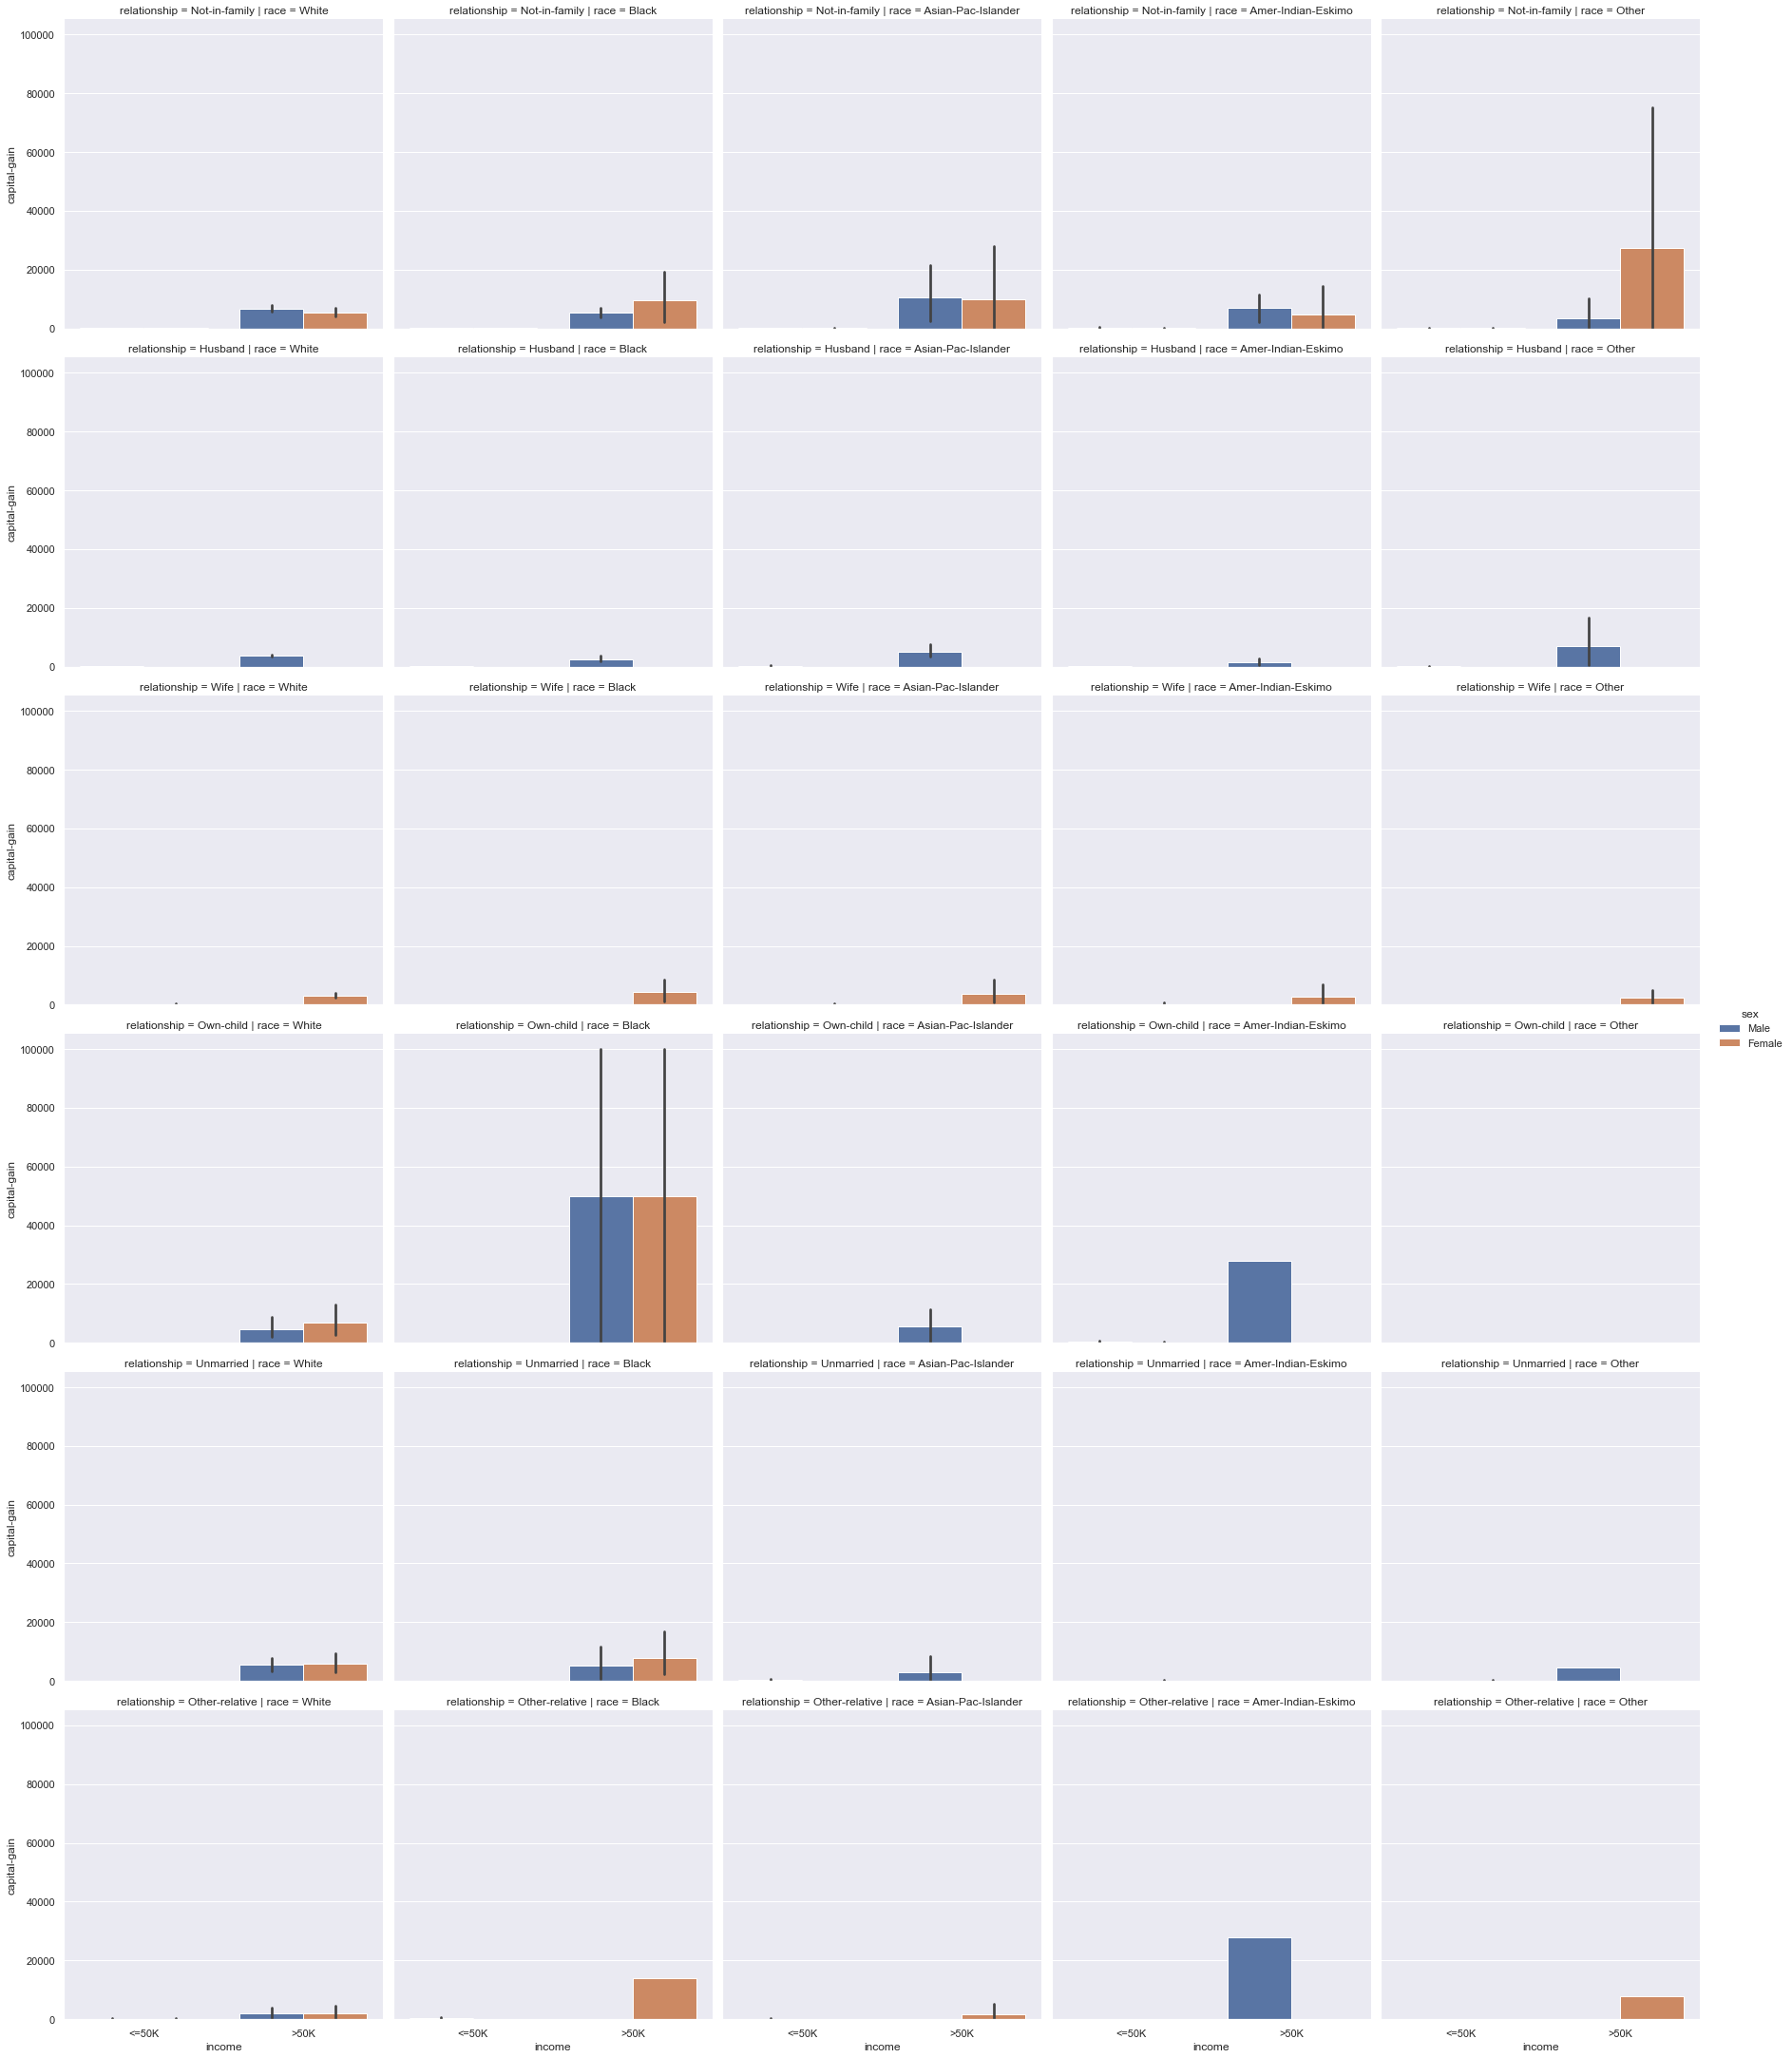

In [12]:
# Overview of the data
sns.catplot( x='income', y='capital-gain',hue='sex', data=adult_data, kind='bar', col='race', row='relationship')

<ipython-input-18-033826fa903a>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


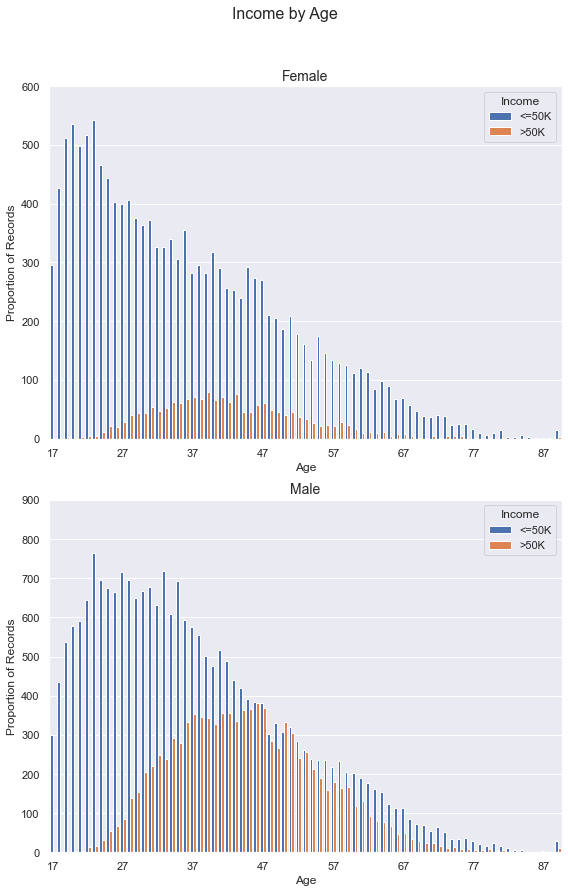

In [18]:
fig, ax =plt.subplots(2,1, figsize = (8, 12))
# fig = plt.figure(figsize = (10,13));

# Initiate plot
sns.countplot(x = 'age', hue = 'income', data = adult_data[adult_data.sex=='Female'], saturation=1, ax=ax[0])
sns.countplot(x = 'age', hue = 'income', data = adult_data[adult_data.sex=='Male'], saturation=1, ax=ax[1])

# Add titles
ax[0].set_title('Female', loc='center', fontsize = 14)
ax[1].set_title('Male', loc='center', fontsize = 14)

# Add labels
ax[0].set_xlabel("Age")
ax[1].set_xlabel("Age")
ax[0].set_ylabel("Proportion of Records")
ax[1].set_ylabel("Proportion of Records")

# Add x_axis ticks
new_ticks = [i.get_text() for i in ax[0].get_xticklabels()]
ax[0].set_xticks(range(0, len(new_ticks), 10))
ax[0].set_xticklabels(new_ticks[::10])
ax[1].set_xticks(range(0, len(new_ticks), 10))
ax[1].set_xticklabels(new_ticks[::10])
#####
label_format = '{:,.0f}'

# nothing done to ax1 as it is a "control chart."

# fixing yticks with "set_yticks"
ticks_loc = ax[0].get_yticks().tolist()
ax[0].set_yticks(ax[0].get_yticks().tolist())


# Optimize y_axis ticks
total_F = adult_data[adult_data.sex=='Female'].shape[0]*1.
total_M = adult_data[adult_data.sex=='Male'].shape[0]*1.
#ax[0].set_yticklabels(map('{:.1f}%'.format, 100*ax[0].yaxis.get_majorticklocs()/total_F))
ax[0].set_yticklabels([label_format.format(x) for x in ticks_loc])
#ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total_M))
ticks_loc = ax[1].get_yticks().tolist()
ax[1].set_yticks(ax[1].get_yticks().tolist())
ax[1].set_yticklabels([label_format.format(x) for x in ticks_loc])

# Change legend location
ax[0].legend(loc=1, title='Income')
ax[1].legend(loc=1, title='Income')

# Set suptitle
fig.suptitle("Income by Age", fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

<ipython-input-33-afc7ed5afb7b>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


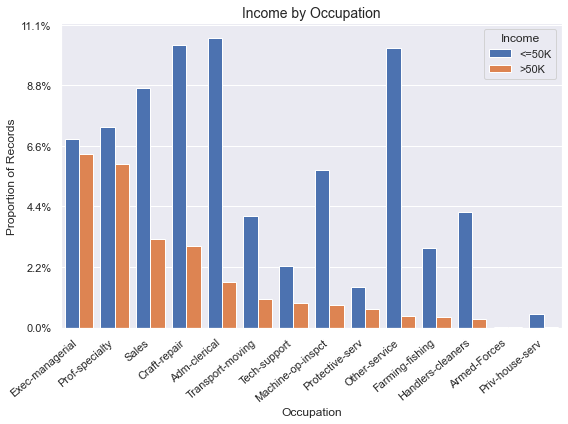

In [33]:
# Use occupation percentage of '>50K' as order of the plot
order = (adult_data.occupation[adult_data.income=='>50K'].value_counts()/adult_data.shape[0]).index

# Plotting the income by age
plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'occupation', hue = 'income', order = order, data = adult_data, saturation=1)
ax.set_title('Income by Occupation', fontsize = 14)
ax.set_xlabel("Occupation")
ax.set_ylabel("Proportion of Records")

# new_ticks = [i.get_text() for i in ax.get_xticklabels()]
# plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = adult_data.shape[0]*1.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.legend(loc=1, title='Income')

plt.tight_layout()
plt.show()

<ipython-input-34-81c585d1acb9>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


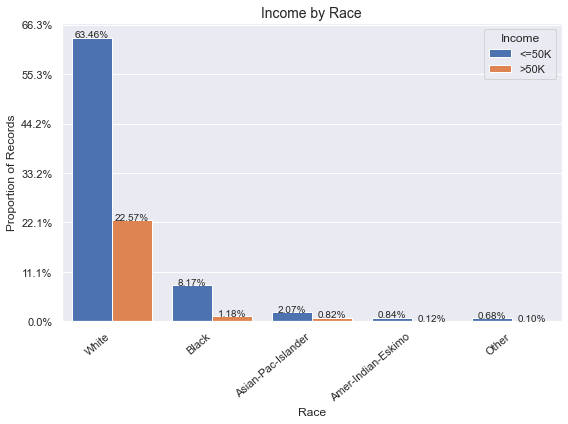

In [34]:
# Use occupation percentage of '>50K' as order of the plot
order = (adult_data.race[adult_data.income=='>50K'].value_counts()/adult_data.shape[0]).index

# Plotting the income by age
plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'race', hue = 'income', order = order, data = adult_data, saturation=1)
ax.set_title('Income by Race', fontsize = 14)
ax.set_xlabel("Race")
ax.set_ylabel("Proportion of Records")

# new_ticks = [i.get_text() for i in ax.get_xticklabels()]
# plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = adult_data.shape[0]*1.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.legend(loc=1, title='Income')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100.0),
            ha="center") 
    
plt.tight_layout()
plt.show()

<ipython-input-35-630fd1a068cd>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))


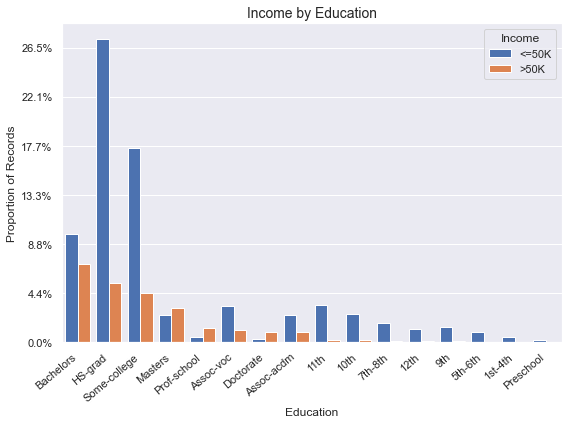

In [35]:
# Use occupation percentage of '>50K' as order of the plot
order = (adult_data.education[adult_data.income=='>50K'].value_counts()/adult_data.shape[0]).index

# Plotting the income by age
plt.figure(figsize=(8,6))
ax = sns.countplot(x = 'education', hue = 'income', order = order, data = adult_data, saturation=1)
ax.set_title('Income by Education', fontsize = 14)
ax.set_xlabel("Education")
ax.set_ylabel("Proportion of Records")

# new_ticks = [i.get_text() for i in ax.get_xticklabels()]
# plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

total = adult_data.shape[0]*1.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
ax.legend(loc=1, title='Income')

plt.tight_layout()
plt.show()

In [36]:
# Total number of records
n_records = adult_data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = np.sum(adult_data.income=='>50K')

# Number of records where individual's incomre is less than $50,000
n_at_most_50k = np.sum(adult_data.income=='<=50K')

# Percentage of indiciduals whose income is more than $50,000
greater_percentage = round(np.mean(adult_data.income=='>50K')*100.00, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percentage))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


## Preparing the Data

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured. After processing the missing entries, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
Skewness may violate model assumptions or may impair the interpretation of feature importance. Therefore, here I will apply logarithmic transformation on the skewed data.

<ipython-input-37-910400a75e71>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


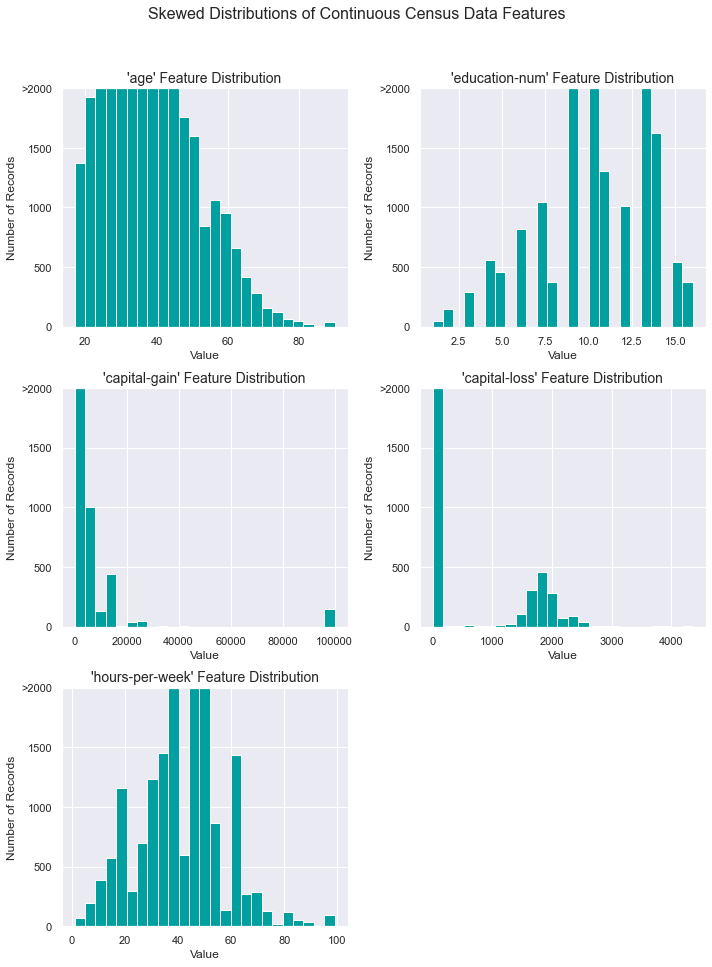

In [37]:
# Check the skewness of numerical variables in data set
num_col = adult_train.dtypes[adult_train.dtypes != 'object'].index

# Create figure
fig = plt.figure(figsize = (10,13));

# Skewed feature plotting
for i, feature in enumerate(adult_train[num_col]):
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(adult_train[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

# Plot aesthetics
fig.suptitle("Skewed Distributions of Continuous Census Data Features", fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

As shown in the graph, there seems skewness in 'capital-gain' and 'capital-loss' features. Use quantitative result to confirm if I need to transform skewness in these two variables.

In [38]:
# Calculate skew and sort
skew_feats = adult_train[num_col].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness

,Skew
capital-gain,11.902682
capital-loss,4.526380
age,0.530228
hours-per-week,0.330869
education-num,-0.305379


In [39]:
# Split the data into features and target label
income_raw = adult_train['income']
feature_raw = adult_train.drop('income', axis=1)

income_raw_test = adult_test['income']
feature_raw_test = adult_test.drop('income', axis=1)

# Log transform the skewed feature highly-skewed feature 'capital-gain' and 'capital-loss'. 
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data=feature_raw)
features_log_transformed[skewed] = feature_raw[skewed].apply(lambda x: np.log(x + 1))

features_log_transformed_test = pd.DataFrame(data=feature_raw_test)
features_log_transformed_test[skewed] = feature_raw_test[skewed].apply(lambda x: np.log(x + 1))


### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, here will perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as 'capital-gain' or 'capital-loss' above); however, it is useful to scale the input attributes for a model that relies on the magnitude of values, such as distance measures used in k-nearest neighbors and in the preparation of coefficients in regression.

In [40]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[num_col] = scaler.fit_transform(features_log_transformed[num_col])

# Transform the test data set
features_log_minmax_transform_test = pd.DataFrame(data = features_log_transformed_test)
features_log_minmax_transform_test[num_col] = scaler.transform(features_log_transformed_test[num_col])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head())
display(features_log_minmax_transform_test.head())

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.109589,Private,11th,0.400000,Never-married,Machine-op-inspct,Own-child,Black,Male,0.000000,0.0,0.397959,United-States
1,0.287671,Private,HS-grad,0.533333,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.000000,0.0,0.500000,United-States
2,0.150685,Local-gov,Assoc-acdm,0.733333,Married-civ-spouse,Protective-serv,Husband,White,Male,0.000000,0.0,0.397959,United-States
3,0.369863,Private,Some-college,0.600000,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,0.777174,0.0,0.397959,United-States
5,0.232877,Private,10th,0.333333,Never-married,Other-service,Not-in-family,White,Male,0.000000,0.0,0.295918,United-States


### Data Preprocessing

There are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. Here convert categorical variables by using the **one-hot encoding** scheme.

Additionally, as with the non-numeric features, I need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can simply encode these two categories as `0` and `1`, respectively. The code cell below implement the following:
 - Use `sklearn.OneHotEncoder` to perform one-hot encoding on the `'features_log_minmax_transform'` data.  
     - Note: Since the test data is separate, in case there are unseen categories in test data which will fail the model, here use sklearn.OneHotEncoder rather the pd.get_dummies()
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [41]:
# One-hot encode the 'features_log_minmax_transform' data using sklearn.OneHotEncoder

# Categorical columns' names
cat_feats = features_log_minmax_transform.dtypes[features_log_minmax_transform.dtypes=='object'].index.tolist()
cat_idx = [features_log_minmax_transform.columns.get_loc(col) for col in cat_feats]

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit and transform the encoder on categorical features
encoded_cat_feats = encoder.fit_transform(features_log_minmax_transform.loc[:,cat_feats])

# Extract one-hot-encoder's feature names
cat_col_name = features_log_minmax_transform.columns.get_values()[cat_idx].tolist()
encoded_cat_feats_name = encoder.get_feature_names(cat_col_name)

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df = pd.DataFrame(encoded_cat_feats, columns=encoded_cat_feats_name)
encoded_cat_feats_df.head()

AttributeError: 'Index' object has no attribute 'get_values'

In [ ]:
# Apply OHE above to transform the test dataset
encoded_cat_feats_test = encoder.transform(features_log_minmax_transform_test.loc[:,cat_feats])

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df_test = pd.DataFrame(encoded_cat_feats_test, columns=encoded_cat_feats_name)
encoded_cat_feats_df_test.head()

In [42]:
# Extract the dataframe with only numerical features
num_feats_df = features_log_minmax_transform[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
X_train = pd.merge(num_feats_df, encoded_cat_feats_df, left_index=True, right_index=True).drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_train = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(X_train.columns)))

# Display several rows of processed dataframe
X_train.head()

NameError: name 'encoded_cat_feats_df' is not defined

In [308]:
# Do the same transformation on test data
# Extract the dataframe with only numerical features
num_feats_df_test = features_log_minmax_transform_test[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
X_test = pd.merge(num_feats_df_test, encoded_cat_feats_df_test, left_index=True, right_index=True)\
            .drop('index', axis=1)

# Encode the 'income_raw' to numerical values
y_test = income_raw_test.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(X_test.columns)))

# Display several rows of processed dataframe
X_test.head()

103 total features after one-hot encoding.


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.109589,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.287671,0.533333,0.000000,0.0,0.500000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.150685,0.733333,0.000000,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.369863,0.600000,0.777174,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.232877,0.333333,0.000000,0.0,0.295918,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Evaluating Model Performance

In this section, I will investigate five different algorithms, and determine which is best at modeling the data. Four of these algorithms will be supervised learners, and the fifth algorithm is known as a *naive predictor*.

### Naive Predictor

Generate a naive predictor to show what a base model without any intelligence would look like. That is if we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? Here assum that we consider more about to correctly predict individual who has incomre over 50K. 


Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision, which is also called the **F$_{0.5}$ score** (or F-score for simplicity).

__Note__:
* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [309]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

# Calculate accuracy, precision and recall
accuracy = np.sum(y_train)/ y_train.count()
recall = np.sum(y_train) / np.sum(y_train)
precision = np.sum(y_train) / y_train.count()

# Calculate F-score using beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5*0.5)* precision* recall/ (0.5*0.5*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2489, F-score: 0.2929]


### Supervised Lerning Models

Apart from bench mark model, I'll chose four other models Logistic Regression, Random Forest, Ensemble Methods (AdaBoost) and Support Vector Machines (SVM) as a candidate to build the predictive model.

- Logistic Regression  

    - Logistic regression doesn't need too many computational resources. 's highly interpretable, and doesn't require input features to be scaled. It doesn't require any tuning, and is wasy to regularize.
    - However, it can't solve non-linear problem with logistic regression since its secision surface is linear. It won't perform well with independent variables that are not correlated to the target variable or the variables correlated to each others
    - In this case, the model is simply doing binary classification and most of features are correlated to the target variable.

- Random Forest  

    - RF can be used in data sets with large number of features and instances. It trains fast due to parallel tree generation. It has low variance compared to single decision tree due to uncorrelated trees.  
    - Prediction time can be higher for complex models with large number of trees. Possible issues with diagonal decision boundaries  
    - In this case, Given large number of training data and one hot encoded categorical features will be a good fit for the given problem.

- Ensemble Methods -- AdaBoost  

    - AdaBoost is easy to implement. It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners. AdaBoost is not prone to overfitting.  
    - AdaBoost is sensitive to noise data. It is highly affected by outliers because it tries to fit each point perfectly. AdaBoost is slower compared to XGBoost. Reference.  
    - In this case, the final goal is to predict if the individual will have salary above 50K or not. AdaBoost, as one of the boosting algorithm, it focuses on classification problems and aims to convert a set of weak classifiers into a strong one. Reference



- Support Vector Machines (SVM)  

    - SVM has a regularisation parameter, which makes the user avoid over-fitting SVM usese the kernel trick, can build in expert knowledge about the problem via engineering the kernel It's defined by a convex optimisation problem for which there are efficient methods Reference  
    - SVM only really covers the determination of the parameters for a given value of the regularisation and kernel parameters and choice of kernel. Therefore, the biggest disadvantages are choosing appropriately hyper parameters of the SVM that will allow for sufficient generalization performance Reference  
    - In this case, the data is not highly skewed/ imbalanced which would be good to use SVM model. The number of features in this case is not too many so that SVM can still work well. And the problem is binary classification which is suitable for SVM. Reference



### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model chosen above more efficiently, it's helpful to create a training and predicting pipeline that can quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

The code block below will implement the following:
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.

In [310]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' 
    start = time() # Get start time
    learner =  learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, average = 'binary', beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, average = 'binary', beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

In the next section:
- Initialize the four models and store them in `'clf_A'`, `'clf_B'`, `'clf_C'` and `'clf_D'`.
  - **Note:** Here use the default settings for each model — will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


In [311]:
# Initialize the three models
clf_A = LogisticRegression(random_state = 42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state = 42)
clf_D = SVC(random_state = 42)


# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = int(len(X_train))
samples_10 = int(len(X_train) / 10)
samples_1 = int(len(X_train) / 100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)


LogisticRegression trained on 301 samples.


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 3016 samples.


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression trained on 30162 samples.
RandomForestClassifier trained on 301 samples.


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 3016 samples.
RandomForestClassifier trained on 30162 samples.
AdaBoostClassifier trained on 301 samples.
AdaBoostClassifier trained on 3016 samples.
AdaBoostClassifier trained on 30162 samples.


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.2

SVC trained on 301 samples.
SVC trained on 3016 samples.


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 30162 samples.


In [312]:
# Quick view on three model's performance
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

LogisticRegression


,1%,10%,100%
acc_test,0.822377,0.840571,0.841368
acc_train,0.850000,0.826667,0.823333
f_test,0.643001,0.682040,0.685646
f_train,0.707071,0.645161,0.637982
pred_time,0.016398,0.076235,0.040350
train_time,0.010597,0.030637,1.456697


RandomForestClassifier


,1%,10%,100%
acc_test,0.817331,0.829084,0.834130
acc_train,0.983333,0.990000,0.970000
f_test,0.630216,0.656668,0.666929
f_train,0.985507,0.991501,0.941828
pred_time,0.104954,0.446685,0.134161
train_time,0.041150,0.234309,1.330996


AdaBoostClassifier


,1%,10%,100%
acc_test,0.823041,0.849270,0.856507
acc_train,0.913333,0.853333,0.850000
f_test,0.642866,0.700780,0.723146
f_train,0.840841,0.702006,0.700935
pred_time,0.230817,0.619552,0.196001
train_time,0.158148,0.615434,3.302659


SVC


,1%,10%,100%
acc_test,0.754316,0.830412,0.839973
acc_train,0.756667,0.810000,0.830000
f_test,0.000000,0.666667,0.685817
f_train,0.000000,0.606557,0.653495
pred_time,0.437135,3.112817,24.697000
train_time,0.009984,1.343176,87.861537


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


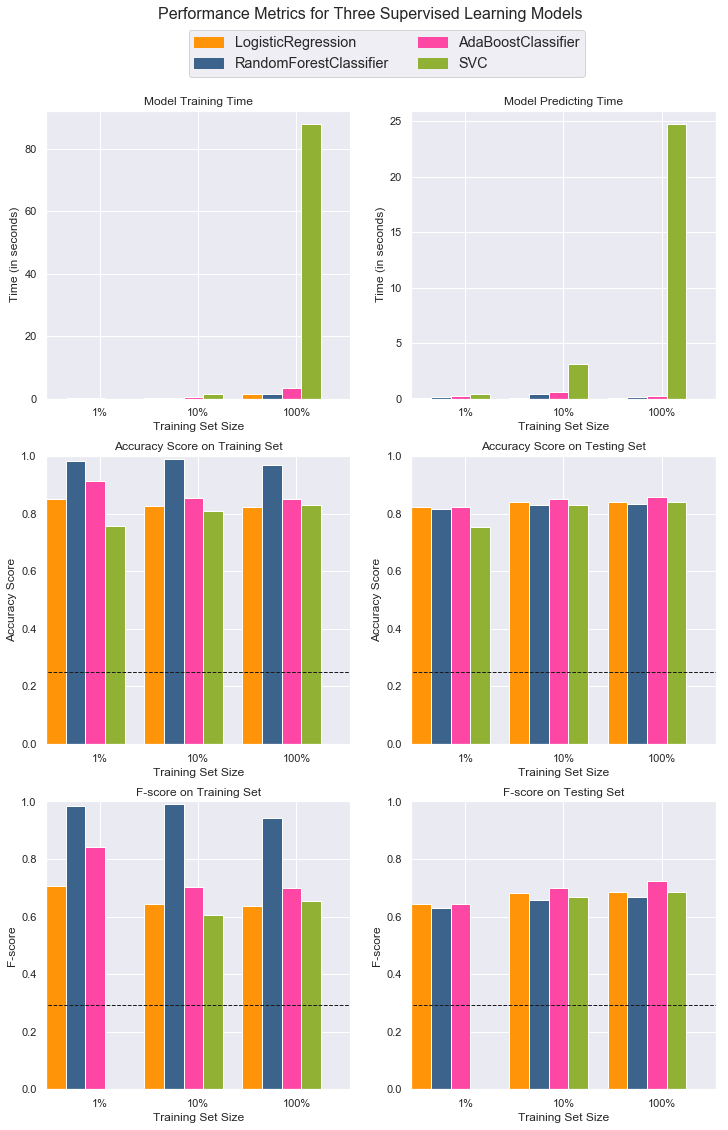

In [313]:
# Run metrics visualization for the three supervised learning models chosen

# Create figure
fig, ax = plt.subplots(3, 2, figsize = (12,18))

# Constants
bar_width = 0.2
colors =  ['#ff9408', '#3b638c', '#fe46a5', '#90b134']

# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time','pred_time', 'acc_train', 'acc_test', 'f_train', 'f_test']):
        for i in np.arange(3):
                
            # Creative plot code
            ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
            ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
            ax[j//2, j%2].set_xlabel("Training Set Size")
            ax[j//2, j%2].set_xlim((-0.1, 3.0))
    
# Add y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Time (in seconds)" )
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 1].set_ylabel("Accuracy Score")
ax[2, 0].set_ylabel("F-score")
ax[2, 1].set_ylabel("F-score")
    
# Add titles
ax[0, 0].set_title("Model Training Time")
ax[0, 1].set_title("Model Predicting Time")
ax[1, 0].set_title("Accuracy Score on Training Set")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[2, 0].set_title("F-score on Training Set")
ax[2, 1].set_title("F-score on Testing Set")
    
# Add horizontal lines for naive predictors
ax[1, 0].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[2, 0].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
ax[2, 1].axhline(y = fscore, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
# Set y-limits for score panels
ax[1, 0].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[2, 0].set_ylim((0, 1))
ax[2, 1].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
plt.legend(handles = patches, bbox_to_anchor = (-0.08, 3.68), \
            loc = 'upper center', borderaxespad = 0., ncol = 2, fontsize = 'x-large')
    
# Aesthetics
plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 0.96)

fig.tight_layout()
fig.show()

## Improving Results
In this section, I will choose from the four supervised learning models the *best* model to use on the test data. I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) to improve upon the untuned model's F-score. 

According to the model performance graph above, although the Random Forest performs best on training set but the AdaBoost Classifier finally predicts best on testing data. Although the accuracy of AdaBoost Classifier is quiet similar to the performance of other models, F-score of AdaBoost is better on both training and testing data when the model is applied to the whole data set. Also, in contrast to Support Vector Classfier which takes dramatically more time to train and predict, the AdaBoost is faster. In terms of binary classification, AdaBoost will also performs good in this case.

### Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`). Use the entire training set for this. The code cell below will implement the following:
- Initialize the classifier I've chosen and store it in `clf`.
- Create a dictionary of parameters to tune for the chosen model.
    - `n_estimators` and `learning_rate` of AdaBoostClassifier
    - `max_depth` and `min_samples_split` of base_estimator
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.


In [314]:
# Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Create the parameters list 
parameters = {'n_estimators':[50,75,100,200], 
              'learning_rate':[0.05,0.1,0.3,1], 
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

start = time()
# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
end = time()

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

print("--- Run time: %s mins ---" % np.round(((end - start)/60),2))

/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8280
F-score on testing data: 0.6518

Optimized Model
------
Final accuracy score on the testing data: 0.8701
Final F-score on the testing data: 0.7518
--- Run time: 22.88 mins ---


In [315]:
print(best_clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=200, random_state=42)


### Final Model Evaluation

|     Metric     |  Benchmark Model  |Unoptimized Model | Optimized Model |
| :------------: | :---------------: |:---------------: | :-------------: | 
| Accuracy Score |      0.2478       |      0.8280      |     0.8701      |
| F-score        |      0.2917       |      0.6518      |     0.7518      |

The optimized model's accuracy on testing data is 0.8701 and F-score is 0.7518. Both of those scores are better than the unoptimized model. Also, the optimized model performs much better than the benchmarks

## Feature Importance

Generally, it's useful to know which features provide the most predictive power when performing supervised learning on a dataset like the census data here. In this case, it means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Here will choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute. Fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Extracting Feature Importance

The code cell below will implement the following:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

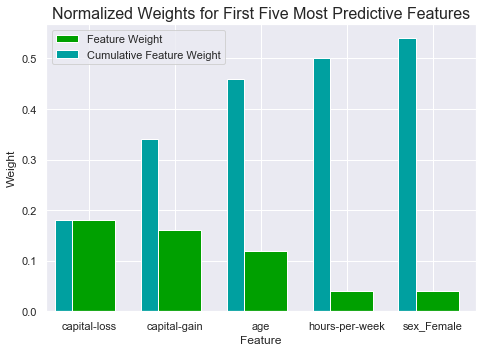

In [316]:
# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Display the five most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (7,5))
plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
        label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)
    
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()  

From the result, the featuer importance put 'capital-loss' the most important feature. It's probably because the bigger capital loss means that the person has to have that volume of money to invest. The 'age' ranks the second one which may because the elder the people the more salary they will have to donor. The 'hours-per-week' and 'sex_Female' ranks the forth and fifth which probably because it's not that sure cases. It's true since maybe the person works longer but have lower unit salary.

### Feature Selection

From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model found earlier, and train it on the same training set *with only the top five important features*. 

In [317]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8701
F-score on testing data: 0.7518

Final Model trained on reduced data
------
Accuracy on testing data: 0.8290
F-score on testing data: 0.6725


As result above show, the model performs a bit worse if I only used important features. The accuracy is 5% lower and the f-score is 7% lower, so in this case I'll still choose to use all feature to build the model unless when the time for fitting model matters a lot.

## Unsupervised clustering
After I build the model predicting whether the individual has the income >50K, I'm gonna try to use unsupervised learning to cluster the population into groups. And see if I could get any insight from the clusters. Since in this case we don't need test data, I'll combine train and test to train clustering model.

### Apply Feature Scaling

Before we apply __dimensionality reduction techniques__ to the data, we need to perform __feature scaling__ so that the __principal component vectors are not influenced by the natural differences in scale for features.__

In [318]:
feature_all = adult_data.drop('income', axis=1)
features_log_transformed_all = pd.DataFrame(data=feature_all)
features_log_transformed_all[skewed] = feature_all[skewed].apply(lambda x: np.log(x + 1))

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

features_log_minmax_transform_all = pd.DataFrame(data = features_log_transformed_all)
features_log_minmax_transform_all[num_col] = scaler.fit_transform(features_log_transformed_all[num_col])

# Apply OHE above to transform the test dataset
encoded_cat_feats_all = encoder.transform(features_log_minmax_transform_all.loc[:,cat_feats])

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df_all = pd.DataFrame(encoded_cat_feats_all, columns=encoded_cat_feats_name)

# Extract the dataframe with only numerical features
num_feats_df_all = features_log_minmax_transform_all[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
adult_data_processed = pd.merge(num_feats_df_all, encoded_cat_feats_df_all, left_index=True, right_index=True)\
                        .drop('index', axis=1)

# Encode the 'income_raw' to numerical values
# y_train = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

print("{} total features after one-hot encoding.".format(len(X_all.columns)))

scaler2 = StandardScaler()
adult_data_processed[X_train.columns] = scaler2.fit_transform(adult_data_processed[X_train.columns].as_matrix())
adult_data_processed.head()


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


103 total features after one-hot encoding.


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.034201,1.128753,2.815336,-0.222752,-0.078120,-0.179133,-0.271285,-1.671940,-0.194353,-0.302710,...,-0.037053,-0.062328,-0.021035,-0.047312,-0.034896,-0.025332,-0.023985,0.308506,-0.042881,-0.022558
1,0.866417,1.128753,-0.300328,-0.222752,-2.326738,-0.179133,-0.271285,-1.671940,-0.194353,3.303493,...,-0.037053,-0.062328,-0.021035,-0.047312,-0.034896,-0.025332,-0.023985,0.308506,-0.042881,-0.022558
2,-0.041455,-0.438122,-0.300328,-0.222752,-0.078120,-0.179133,-0.271285,0.598108,-0.194353,-0.302710,...,-0.037053,-0.062328,-0.021035,-0.047312,-0.034896,-0.025332,-0.023985,0.308506,-0.042881,-0.022558
3,1.093385,-1.221559,-0.300328,-0.222752,-0.078120,-0.179133,-0.271285,0.598108,-0.194353,-0.302710,...,-0.037053,-0.062328,-0.021035,-0.047312,-0.034896,-0.025332,-0.023985,0.308506,-0.042881,-0.022558
4,-0.798015,1.128753,-0.300328,-0.222752,-0.078120,-0.179133,-0.271285,0.598108,-0.194353,-0.302710,...,-0.037053,-0.062328,-0.021035,-0.047312,-0.034896,-0.025332,-0.023985,-3.241430,-0.042881,-0.022558


### Perform Dimensionality Reduction
On scaled data, now ready to apply dimensionality reduction techniques.

- Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. - Plot the cumulative or sequential values. Based on what I find, select a value for the number of transformed features I'll retain for the clustering part of the project.

In [319]:
# Apply PCA to the data
pca = PCA()
model = pca.fit_transform(adult_data_processed)

In [320]:
# Investigate the variance accounted for by each principal component.

def plot_pc(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

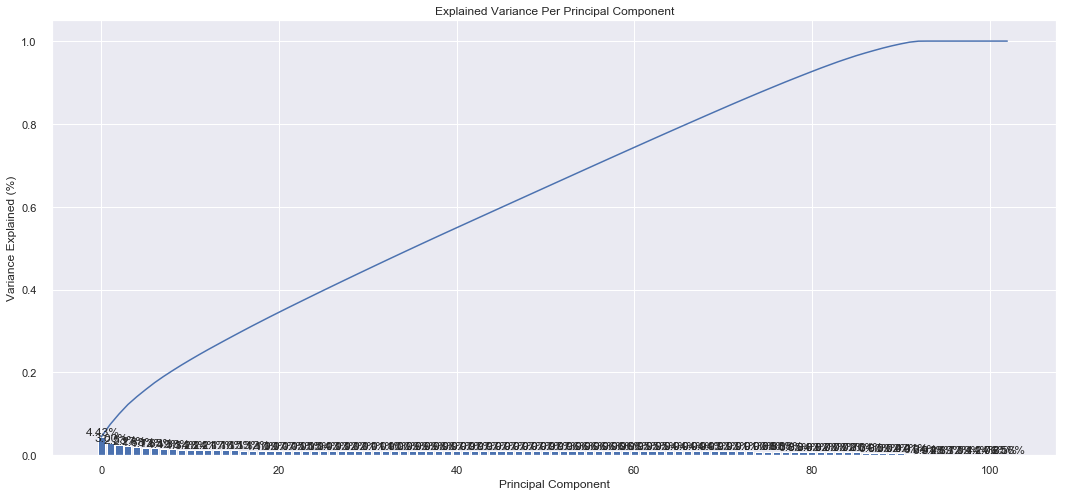

In [321]:
plot_pc(pca)

In [322]:
# Find appropriate number of components to retain
start = time()
for i in np.arange(20, len(pca.explained_variance_ratio_), 3):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())
end = time()
print(end - start)

For 20 components, explained variance: 0.33439892353123
For 23 components, explained variance: 0.3664634932896248
For 26 components, explained variance: 0.397989717043098
For 29 components, explained variance: 0.42896840605945985
For 32 components, explained variance: 0.4595852699444481
For 35 components, explained variance: 0.48988629671098183
For 38 components, explained variance: 0.51976845937598
For 41 components, explained variance: 0.549271038528838
For 44 components, explained variance: 0.5785367642441963
For 47 components, explained variance: 0.6077458532767466
For 50 components, explained variance: 0.6369126064269938
For 53 components, explained variance: 0.6660449142008731
For 56 components, explained variance: 0.6951243501048395
For 59 components, explained variance: 0.7240907781955703
For 62 components, explained variance: 0.7528911866556682
For 65 components, explained variance: 0.7815035869146852
For 68 components, explained variance: 0.8098432724969058
For 71 components,

In [323]:
pca = PCA(n_components=80)
pca_80 = pca.fit_transform(adult_data_processed)

### Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

- To investigate the features, map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 

In [324]:
# Define a function to show the weight of each features by dimension
def show_weight(full_dataset, pca, comp_n, feat_n):
    '''
    Display the weight of each feature in dimension i
    INPUT: 
        full_dataset: dataset
        pca: PCA model fitted with data
        comp_n: index of component
        feat_n: feature number
    OUTPUT: weight of each feature 
    '''
    components = pd.DataFrame(np.round(pca.components_, 4), columns=full_dataset.keys()).iloc[comp_n - 1]
    components.sort_values(ascending=False, inplace=True)
    top2n_components = pd.concat([components.head(feat_n), components.tail(feat_n)])

    # Plot the result
    top2n_components.plot(kind='bar', 
                          title='Top {} weighted features for PCA component {}'.format(feat_n*2, comp_n),
                          figsize=(12, 6))
    plt.show()
#     top_components = pd.concat([components.iloc[:5,:],components.iloc[-5:]]).reset_index()
    return top2n_components

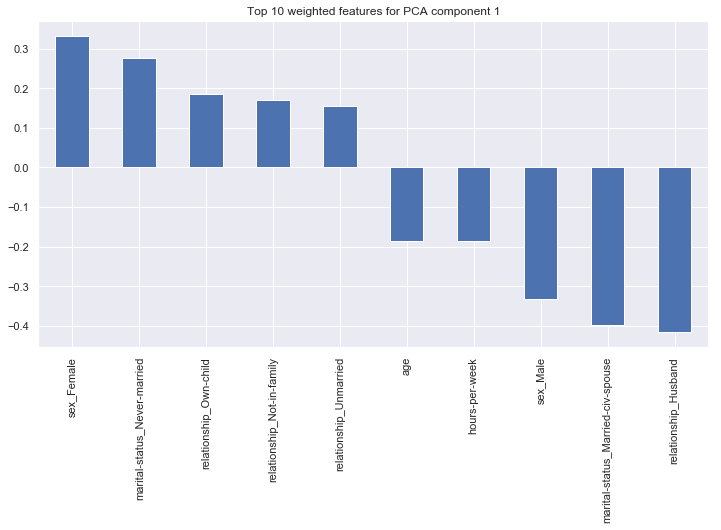

sex_Female                           0.3330
marital-status_Never-married         0.2760
relationship_Own-child               0.1861
relationship_Not-in-family           0.1710
relationship_Unmarried               0.1546
age                                 -0.1849
hours-per-week                      -0.1864
sex_Male                            -0.3330
marital-status_Married-civ-spouse   -0.3984
relationship_Husband                -0.4160
Name: 0, dtype: float64

In [325]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components1 = show_weight(adult_data_processed, pca, 1, 5)
components1

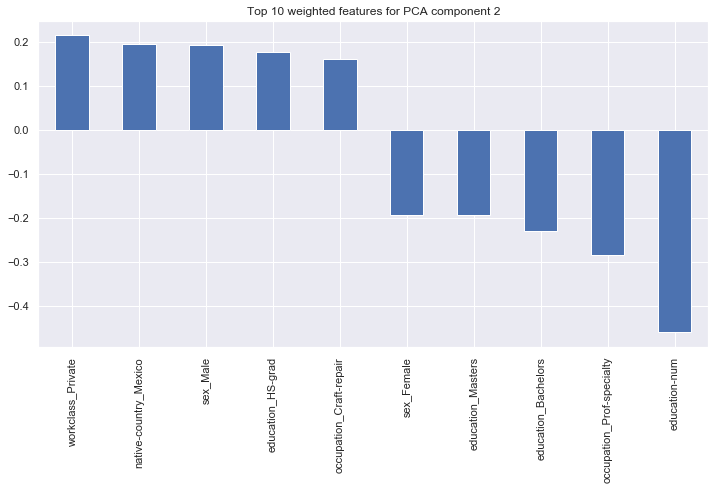

workclass_Private            0.2139
native-country_Mexico        0.1939
sex_Male                     0.1930
education_HS-grad            0.1756
occupation_Craft-repair      0.1601
sex_Female                  -0.1930
education_Masters           -0.1939
education_Bachelors         -0.2301
occupation_Prof-specialty   -0.2858
education-num               -0.4595
Name: 1, dtype: float64

In [326]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components2 = show_weight(adult_data_processed, pca, 2, 5)
components2

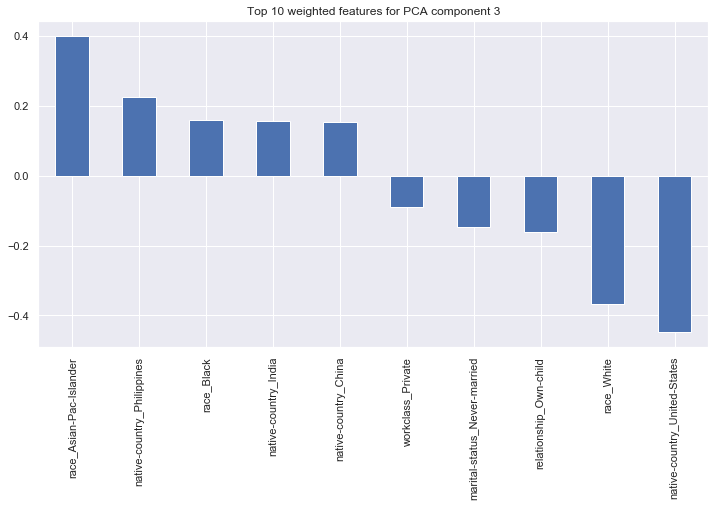

race_Asian-Pac-Islander         0.4008
native-country_Philippines      0.2248
race_Black                      0.1603
native-country_India            0.1562
native-country_China            0.1535
workclass_Private              -0.0902
marital-status_Never-married   -0.1466
relationship_Own-child         -0.1615
race_White                     -0.3682
native-country_United-States   -0.4475
Name: 2, dtype: float64

In [327]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components3 = show_weight(adult_data_processed, pca, 3, 5)
components3

Observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

From the analysis above, it shows detail of how each feature distibute within each dimension. Analyse the first three dimensions along with top 10 features in details.

#### Dimension 1
- In the first dimension, it's positively affected by  
    - sex_Female                              0.3330
    - marital-status_Never-married            0.2760
    - relationship_Own-child                  0.1861
    - relationship_Not-in-family              0.1710
    - relationship_Unmarried                  0.1546
- In the first dimension, it's positively affected by  
    - age                                    -0.1849
    - hours-per-week                         -0.1864
    - sex_Male                               -0.3330
    - marital-status_Married-civ-spouse      -0.3984
    - relationship_Husband                   -0.4160


#### Dimension 2
- In the second dimension, it's positively affected by   
    - workclass_Private                    0.2139
    - native-country_Mexico                0.1939
    - sex_Male                             0.1930
    - education_HS-grad                    0.1756
    - occupation_Craft-repair              0.1601
- In the second dimension, it's positively affected by  
    - sex_Female                          -0.1930
    - education_Masters                   -0.1939
    - education_Bachelors                 -0.2301
    - occupation_Prof-specialty           -0.2858
    - education-num                       -0.4595

#### Dimension 3
- In the third dimension, it's positively affected by   
    - race_Asian-Pac-Islander                 0.4008
    - native-country_Philippines              0.2248
    - race_Black                              0.1603
    - native-country_India                    0.1562
    - native-country_China                    0.1535
- In the third dimension, it's positively affected by  
    - workclass_Private                      -0.0902
    - marital-status_Never-married           -0.1466
    - relationship_Own-child                 -0.1615
    - race_White                             -0.3682
    - native-country_United-States           -0.4475

### Apply Clustering
We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. 
- Perform the above two steps for a number of different cluster counts.

In [328]:
# Investigate the change in within-cluster distance across number of clusters.
def get_kmeans_score(data, center):
    '''
    return the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    
    # Then fit the model to you data using the fit mothod
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [329]:
scores = []
centers = list(range(1, 12))

start = time()

for center in centers:
    print('Fitting k = {} '.format(center))
    scores.append(get_kmeans_score(pca_80, center))
end = time()

print("--- Run time: %s mins ---" % np.round(((end - start)/60),2))

Fitting k = 1 
Fitting k = 2 
Fitting k = 3 
Fitting k = 4 
Fitting k = 5 
Fitting k = 6 
Fitting k = 7 
Fitting k = 8 
Fitting k = 9 
Fitting k = 10 
Fitting k = 11 
--- Run time: 0.59 mins ---


Text(0.5, 1.0, 'SSE vs. K')

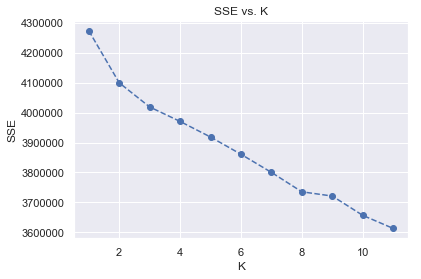

In [330]:
# Plot the SSE value to decide the K value
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')


In [331]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=2)
model = kmeans.fit(pca_80)

Try different K value range from 6 to 30, store SSE and compare to decide the final K value. As shown in plot above, there's no clear elbow, here choose 6 as cluster number since there's a relatively dramatice decrease at that point.

In [332]:
# Store the prediction
adult_predict = pd.DataFrame(np.array(model.predict(pca_80)), columns=['Prediction'])

# Count the cluster number
cluster_cnt = adult_predict['Prediction'].value_counts().sort_index()
display(cluster_cnt)

cluster_prop = pd.DataFrame((cluster_cnt/cluster_cnt.sum()), columns=['Prediction']).reset_index()
cluster_prop.set_index('index', inplace=True)
display(cluster_prop)


0    18957
1    26265
Name: Prediction, dtype: int64

,Prediction
index,
0,0.419199
1,0.580801


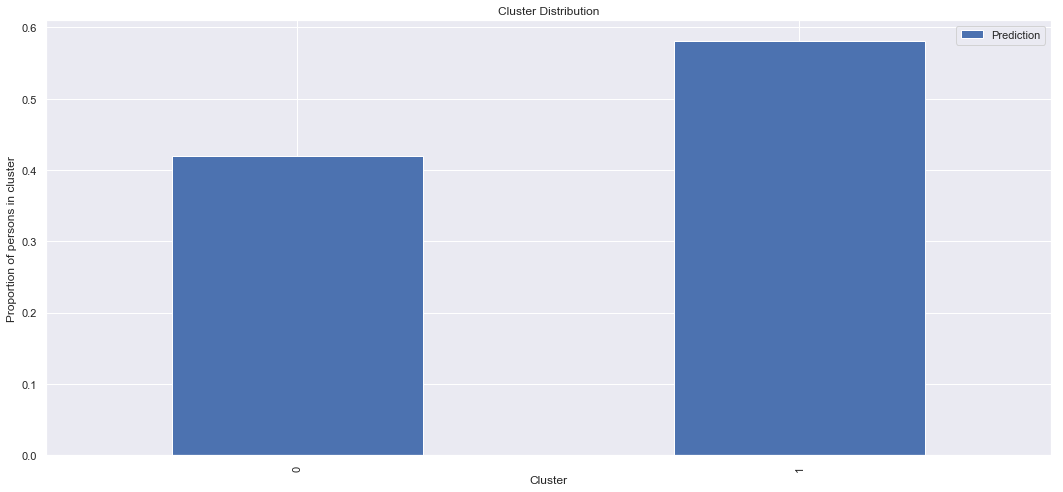

In [333]:
cluster_prop = cluster_prop.reset_index()
cluster_prop.plot(x = 'index', y = 'Prediction', kind = 'bar', figsize = (18,8 ))
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Proportion of persons in cluster')
plt.show()

In [334]:
# Investigate top components of cluster 0
cluster0_components = pd.Series(kmeans.cluster_centers_[0])
cluster0_components.sort_values(ascending=False, inplace=True)
cluster0_components.head(5)

1     0.351713
5     0.197245
6     0.160320
2     0.085532
77    0.076133
dtype: float64

In [335]:
# To get the detail of cluster, transfer cluster back to analyze the principle component
cluster0 = scaler2.inverse_transform(pca.inverse_transform(pca_80))[adult_predict.Prediction==0]
cluster0_features = pd.DataFrame(data = np.round(cluster0), columns= adult_data_processed.columns)
# cluster0_features.head()

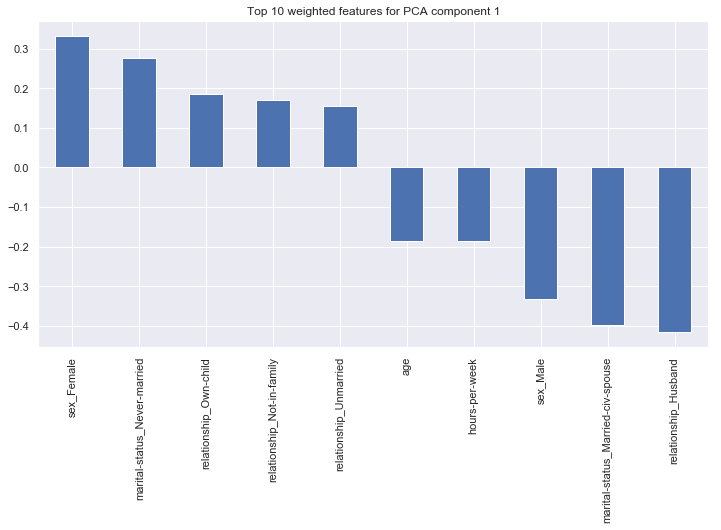

sex_Female                           0.3330
marital-status_Never-married         0.2760
relationship_Own-child               0.1861
relationship_Not-in-family           0.1710
relationship_Unmarried               0.1546
age                                 -0.1849
hours-per-week                      -0.1864
sex_Male                            -0.3330
marital-status_Married-civ-spouse   -0.3984
relationship_Husband                -0.4160
Name: 0, dtype: float64

In [336]:
# Chenck top features in first component
show_weight(cluster0_features, pca, 1, 5)

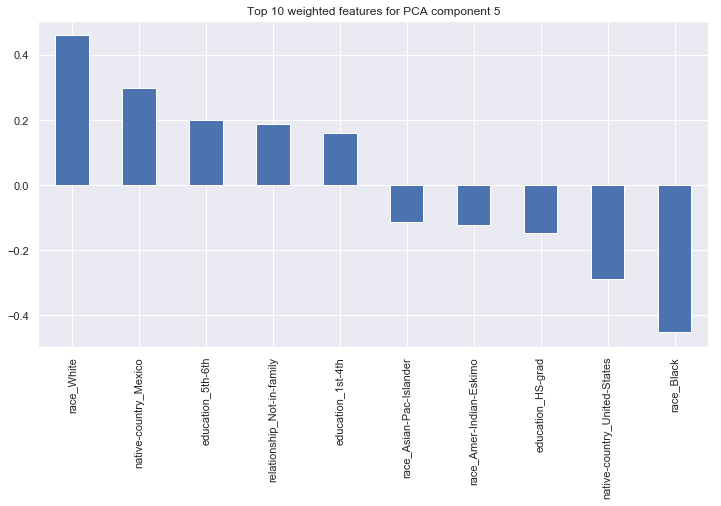

race_White                      0.4594
native-country_Mexico           0.2979
education_5th-6th               0.2013
relationship_Not-in-family      0.1866
education_1st-4th               0.1607
race_Asian-Pac-Islander        -0.1134
race_Amer-Indian-Eskimo        -0.1239
education_HS-grad              -0.1468
native-country_United-States   -0.2890
race_Black                     -0.4509
Name: 4, dtype: float64

In [337]:
# Chenck top features in first component
show_weight(cluster0_features, pca, 5, 5)

In [338]:
# Investigate top components of cluster 1
cluster1_components = pd.Series(kmeans.cluster_centers_[1])
cluster1_components.sort_values(ascending=False, inplace=True)
cluster1_components.head(5)

0     1.621588
4     0.140686
10    0.063942
7     0.062245
68    0.039961
dtype: float64

In [339]:
# To get the detail of cluster, transfer cluster back to analyze the principle component
cluster1 = scaler2.inverse_transform(pca.inverse_transform(pca_80))[adult_predict.Prediction==1]
cluster1_features = pd.DataFrame(data = np.round(cluster1), columns= adult_data_processed.columns)
# cluster1_features.head()

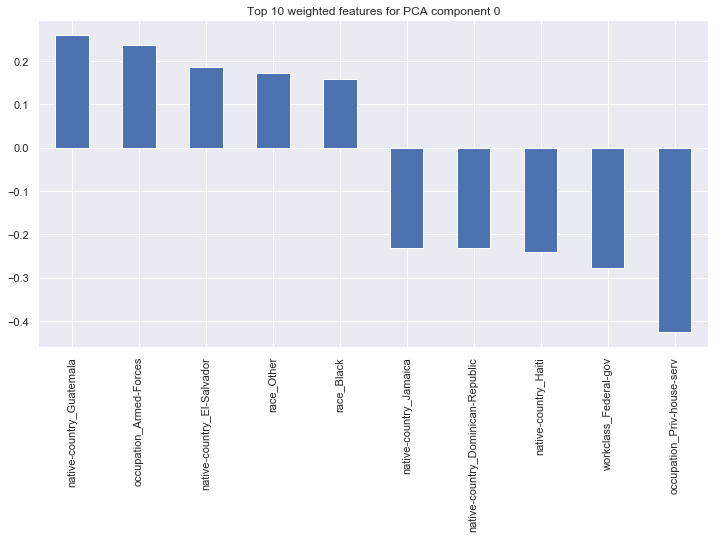

native-country_Guatemala             0.2594
occupation_Armed-Forces              0.2368
native-country_El-Salvador           0.1866
race_Other                           0.1720
race_Black                           0.1575
native-country_Jamaica              -0.2316
native-country_Dominican-Republic   -0.2316
native-country_Haiti                -0.2411
workclass_Federal-gov               -0.2783
occupation_Priv-house-serv          -0.4250
Name: 79, dtype: float64

In [340]:
# Chenck top features in top component
show_weight(cluster1_features, pca, 0, 5)

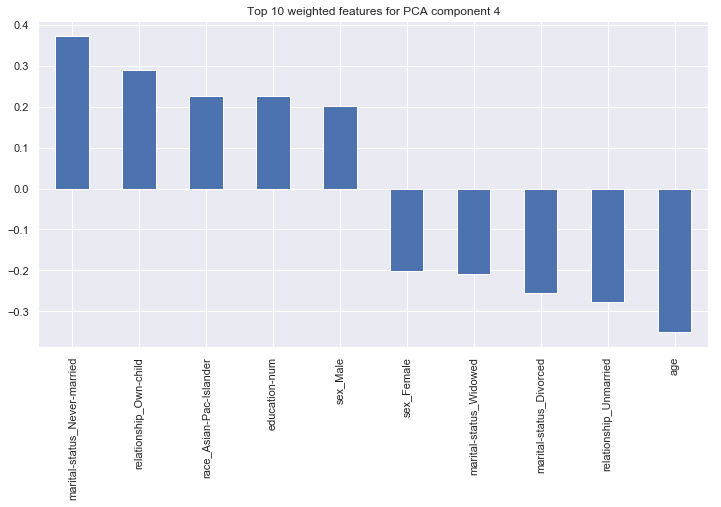

marital-status_Never-married    0.3739
relationship_Own-child          0.2910
race_Asian-Pac-Islander         0.2261
education-num                   0.2255
sex_Male                        0.2015
sex_Female                     -0.2015
marital-status_Widowed         -0.2097
marital-status_Divorced        -0.2552
relationship_Unmarried         -0.2772
age                            -0.3509
Name: 3, dtype: float64

In [341]:
# Chenck top features in top component
show_weight(cluster1_features, pca, 4, 5)

In [ ]:
amrani4215 mohamed.lamrani.505960